# Singal To Noise All Models
 - Calculates the singal to nosie for all models in longrunmip for GMST
 - Fraction of models stable for windows for GMST
 
 PHD-9:
 * read_and_merge_netcdfs moved from longrunmip_loader to open_ds


In [12]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from importlib import reload
import matplotlib as mpl
import string
import matplotlib.ticker as mticker
import os, sys
import constants
sys.path.append(constants.MODULE_DIR)
import sn_plotting as sn_plot
import xarray_class_accessors as xca
import open_ds
import signal_to_noise as sn
import xarray_extender as xce
import utils
from classes import ExperimentTypes
from itertools import groupby
warnings.filterwarnings('ignore')
logger = utils.get_notebook_logger()

from functools import partial

In [13]:
import dask.distributed
import tempfile
tempdir = tempfile.TemporaryDirectory('dask-worker-space')
dask.distributed.Client(local_directory=tempdir.name, memory_limit='32gb')

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:35391/status,
Dashboard: http://127.0.0.1:35391/status,Workers: 4
Total threads: 16,Total memory: 119.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35837,Workers: 4
Dashboard: http://127.0.0.1:35391/status,Total threads: 16
Started: Just now,Total memory: 119.21 GiB
Comm: tcp://127.0.0.1:37685,Total threads: 4
Dashboard: http://127.0.0.1:38401/status,Memory: 29.80 GiB
Nanny: tcp://127.0.0.1:42659,


In [224]:
VARIABLE_INFO = constants.VARIABLE_INFO
VARIABLE_INFO

notebook_number='03_01'

In [225]:
models_to_get =  constants.LONGRUNMIP_MODELS
utils.pprint_list(models_to_get, num_start_items=6)

lenght = 6
 0. ccsm3
 1. cnrmcm61
 2. hadcm3l
 3. ipslcm5a
 4. mpiesm11
 5. mpiesm12


In [227]:
reload(constants)
constants.EXPERIMENTS_TO_RUN

[{'variable': 'tas', 'mask': None, 'hemisphere': 'global'},
 {'variable': 'tas', 'mask': 'land', 'hemisphere': 'global'},
 {'variable': 'pr', 'mask': None, 'hemisphere': 'global'},
 {'variable': 'pr', 'mask': 'land', 'hemisphere': 'global'},
 {'variable': 'tos', 'mask': 'sea', 'hemisphere': 'global'}]

In [239]:
reload(open_ds)

<module 'open_ds' from '/home/563/ab2313/Documents/PhD/modules/open_ds.py'>

In [240]:
%%time
all_experiment_ds, all_control_ds = open_ds.get_all_experiment_ds(constants.EXPERIMENTS_TO_RUN,
                                                          constants.LONGRUNMIP_DIR, models_to_get)
all_experiment_ds


- {'variable': 'tas', 'mask': None, 'hemisphere': 'global'}
- Removing first 10 steps
ccsm3, cnrmcm61, hadcm3l, ipslcm5a, mpiesm11, mpiesm12, 
- {'variable': 'tas', 'mask': 'land', 'hemisphere': 'global'}
- Removing first 10 steps
ccsm3, cnrmcm61, hadcm3l, ipslcm5a, mpiesm11, mpiesm12, 
- {'variable': 'pr', 'mask': None, 'hemisphere': 'global'}
- Removing first 10 steps
ccsm3, cnrmcm61, hadcm3l, ipslcm5a, mpiesm11, mpiesm12, 
- {'variable': 'pr', 'mask': 'land', 'hemisphere': 'global'}
- Removing first 10 steps
ccsm3, cnrmcm61, hadcm3l, ipslcm5a, mpiesm11, mpiesm12, 
- {'variable': 'tos', 'mask': 'sea', 'hemisphere': 'global'}
- Removing first 10 steps
- Removing first 200 steps
ccsm3, cnrmcm61, hadcm3l, ipslcm5a, mpiesm11, mpiesm12, CPU times: user 20.5 s, sys: 13.8 s, total: 34.4 s
Wall time: 54.1 s


<xarray.Dataset>
Dimensions:          (time: 1200, model: 6)
Coordinates:
  * time             (time) object 0001-12-31 00:00:00 ... 1200-12-31 00:00:00
  * model            (model) <U8 'ccsm3' 'cnrmcm61' ... 'mpiesm11' 'mpiesm12'
Data variables:
    tas_global       (model, time) float64 2.283 2.567 2.734 ... nan nan nan
    tas_land_global  (model, time) float64 3.075 3.226 3.606 ... nan nan nan
    pr_global        (model, time) float64 28.58 48.38 44.16 ... nan nan nan
    pr_land_global   (model, time) float64 51.81 129.5 92.32 ... nan nan nan
    tos_sea_global   (model, time) float64 1.305 1.661 1.691 ... nan nan nan

In [241]:
RUN_PARAMS = dict(start_window =20, end_window = 370, step_window=2)# 370 is standard end window
RUN_PARAMS['end_window']

370

In [242]:
max_effective_length = 600 # sn.get_upper_lim(abrupt4x_mean, RUN_PARAMS['end_window']) # Broken
max_effective_length

600

In [243]:
%%time
stable_sn_ds, unstable_sn_ds = all_experiment_ds.sn_ds.sn_multiwindow(all_control_ds,
            start_window = RUN_PARAMS['start_window'], end_window=RUN_PARAMS['end_window'],
            step_window=RUN_PARAMS['step_window'], parallel=True)

- 
====tas_global


Experiment
--------

26, 20, 38, 56, 32, 44, 62, 50, 74, 68, 86, 80, 92, 98, 104, 110, 40, 34, 76, 100, 46, 94, 64, 70, 52, 22, 58, 88, 28, 106, 112, 82, 42, 36, 48, 78, 24, 66, 54, 60, 96, 72, 90, 108, 30, 84, 114, 116, 122, 128, 102, 140, 146, 134, 158, 152, 164, 170, 176, 182, 188, 194, 200, 118, 124, 130, 206, 136, 148, 172, 142, 178, 166, 160, 190, 154, 184, 120, 196, 202, 126, 132, 208, 168, 162, 180, 192, 138, 150, 174, 186, 156, 204, 198, 212, 218, 144, 224, 230, 236, 210, 242, 248, 254, 260, 266, 272, 278, 284, 290, 220, 296, 214, 226, 238, 232, 244, 256, 302, 250, 280, 268, 292, 286, 262, 222, 274, 298, 228, 234, 258, 240, 252, 216, 246, 282, 270, 294, 288, 264, 304, 308, 314, 276, 320, 300, 326, 332, 338, 344, 350, 306, 356, 362, 368, 310, 316, 328, 322, 334, 346, 352, 340, 358, 364, 312, 318, 330, 324, 336, 348, 342, 354, 366, 360, 
Control
------

32, 26, 20, 44, 38, 50, 56, 62, 68, 86, 74, 80, 92, 98, 104, 110, 28, 70, 88, 46, 82, 52, 40, 106, 34, 112,

26, 32, 20, 38, 44, 50, 56, 62, 68, 74, 80, 86, 92, 98, 110, 104, 52, 64, 22, 46, 70, 34, 106, 76, 82, 28, 58, 94, 54, 48, 100, 24, 112, 40, 66, 88, 84, 108, 36, 30, 72, 116, 96, 60, 102, 78, 122, 42, 128, 134, 140, 118, 146, 90, 152, 114, 158, 164, 170, 176, 182, 188, 142, 120, 200, 194, 148, 154, 130, 136, 124, 206, 166, 160, 178, 172, 156, 150, 184, 212, 190, 144, 202, 196, 126, 138, 132, 168, 180, 174, 208, 162, 218, 214, 186, 192, 198, 224, 230, 236, 242, 248, 204, 254, 266, 260, 210, 272, 220, 216, 278, 226, 284, 290, 238, 232, 256, 244, 250, 268, 296, 262, 274, 280, 228, 302, 286, 292, 308, 222, 240, 234, 246, 258, 252, 270, 298, 276, 294, 304, 310, 314, 264, 288, 282, 320, 326, 332, 338, 350, 344, 356, 362, 306, 312, 368, 300, 316, 334, 322, 352, 340, 328, 346, 364, 358, 318, 336, 354, 324, 342, 348, 366, 360, 330, CPU times: user 47 s, sys: 14.8 s, total: 1min 1s
Wall time: 5min 7s


In [244]:
models_to_get

['ccsm3', 'cnrmcm61', 'hadcm3l', 'ipslcm5a', 'mpiesm11', 'mpiesm12']

In [266]:
to_concat = []
for model in models_to_get:
    stable_year_da = sn.get_stable_point_all_datavars(unstable_sn_ds.sel(model=model))
    stable_year_da = stable_year_da.rename({'model': 'variable'})
    stable_year_da = stable_year_da.expand_dims('model').assign_coords(model=('model', [model]))
    to_concat.append(stable_year_da)
    
stable_year_ds = xr.concat(to_concat, dim='model')

In [267]:
stable_year_ds

<xarray.Dataset>
Dimensions:   (variable: 5, window: 175, model: 6)
Coordinates:
  * variable  (variable) <U15 'tas_global' ... 'tos_sea_global'
  * window    (window) int64 20 22 24 26 28 30 32 ... 358 360 362 364 366 368
  * model     (model) <U8 'ccsm3' 'cnrmcm61' 'hadcm3l' ... 'mpiesm11' 'mpiesm12'
Data variables:
    time      (model, variable, window) int64 21 30 29 20 55 ... 569 570 570 569

In [268]:
stable_year_ds.variable.values

array(['tas_global', 'tas_land_global', 'pr_global', 'pr_land_global',
       'tos_sea_global'], dtype='<U15')

In [269]:
experiment_colors = {'tas_global': 'red', 'tas_land_global': 'lightcoral',
                     'pr_global': 'brown', 'pr_land_global': 'peru', 
                    'sic_sea_global': 'blue', 'sic_sea_northern_hemisphere': 'darkblue',
                       'sic_sea_southern_hemisphere': 'cornflowerblue', 'tos_sea_global': 'orange'}

In [270]:
def plot_year_of_stability(ds, varible_to_loop: str):
    
    plt.style.use('seaborn-darkgrid')
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)

    for variable in ds[varible_to_loop].values:
        color = experiment_colors[variable]
        label = variable.replace('_', ' - ').replace('sea', '')

        da = ds.sel(variable=variable).time.plot(ax=ax,y='window', label=label,
                                                 linewidth=1.5, color=color, alpha=0.8)
    model = str(ds.model.values)
    ECS = constants.MODEL_PARAMS[model]['ECS']
    ax.set_title(f'{model} Year of Stabilisation (ECS={ECS}K)', fontsize=15)

    ax.legend(fontsize=15)
    ax.set_xlim(-1, 830)
    ax.set_ylim(20, 370)
    
    return fig, ax

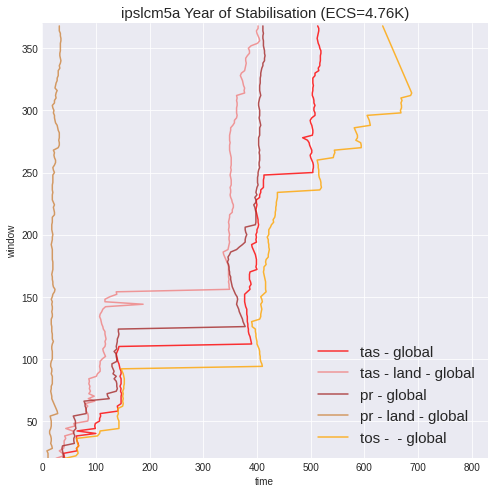

In [271]:
model = 'ipslcm5a'
fig, ax = plot_year_of_stability(stable_year_ds.sel(model=model), 'variable')
save_name = os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL,
                         f'{notebook_number}_{model}_multivariate_year_of_stabilisation.png')
fig.savefig(save_name, dpi=200, bboox_inches='tight')

/home/563/ab2313/gdata/images/PhD/top_level/03_01_ccsm3_multivariate_year_of_stabilisation.png
/home/563/ab2313/gdata/images/PhD/top_level/03_01_cnrmcm61_multivariate_year_of_stabilisation.png
/home/563/ab2313/gdata/images/PhD/top_level/03_01_hadcm3l_multivariate_year_of_stabilisation.png
/home/563/ab2313/gdata/images/PhD/top_level/03_01_ipslcm5a_multivariate_year_of_stabilisation.png
/home/563/ab2313/gdata/images/PhD/top_level/03_01_mpiesm11_multivariate_year_of_stabilisation.png
/home/563/ab2313/gdata/images/PhD/top_level/03_01_mpiesm12_multivariate_year_of_stabilisation.png


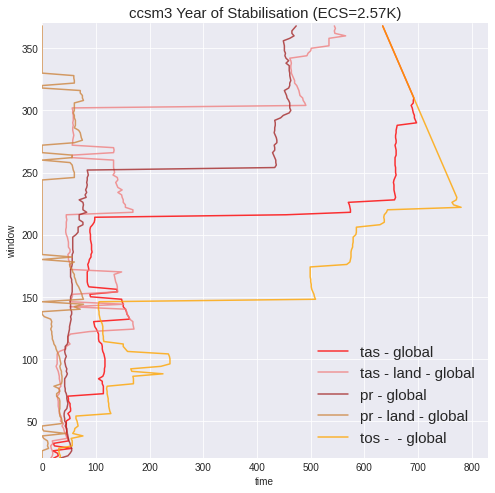

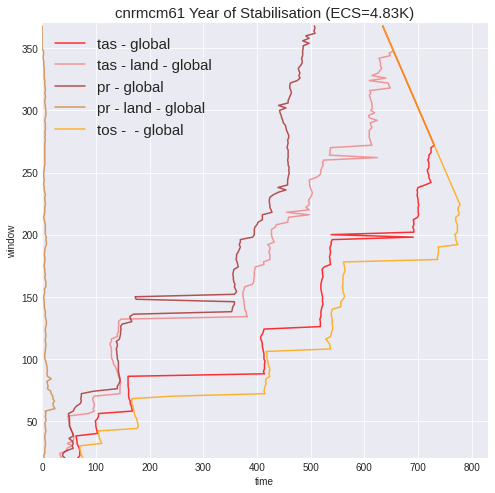

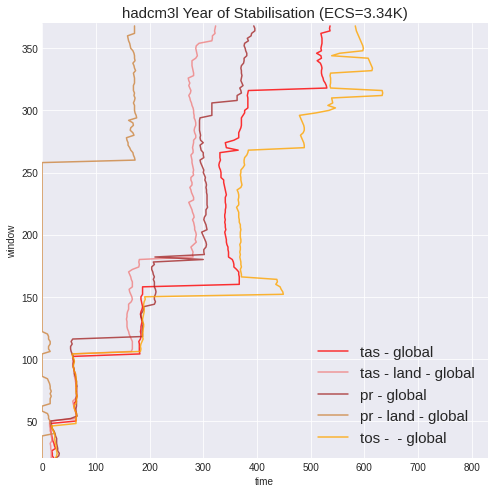

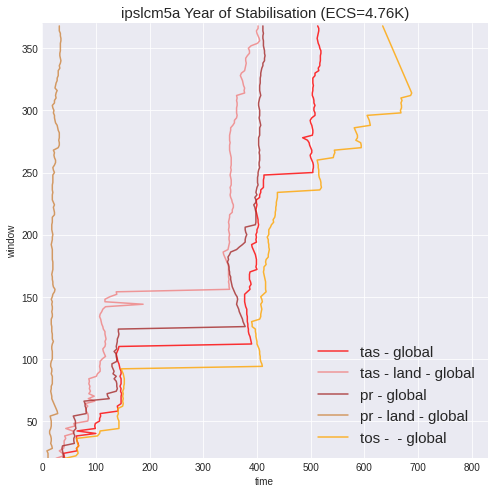

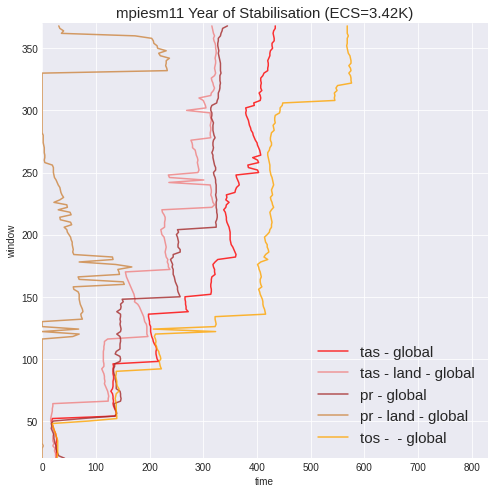

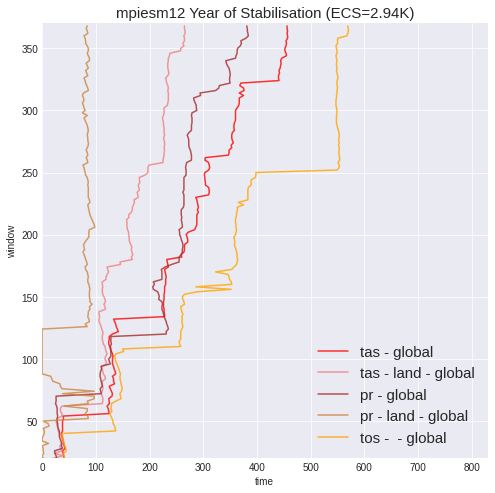

In [272]:
for model in stable_year_ds.model.values:
    fig, ax = plot_year_of_stability(stable_year_ds.sel(model=model), 'variable')
    save_name = os.path.join(constants.IMAGE_SAVE_DIR_TOP_LEVEL,
                             f'{notebook_number}_{model}_multivariate_year_of_stabilisation.png')
    print(save_name)
    fig.savefig(save_name, dpi=200, bboox_inches='tight')